In [1]:
import sys
import numpy as np
import torch
from torch import nn
from torch.autograd import gradcheck

import matplotlib.pyplot as plt
import pandas as pd

import mnp

In [2]:
#Check Gradient
n = 2
layer_sizes = np.ones(1, dtype=np.int64)
layer_sizes *= 1

#Generate input for DSF
s_input, m_input = mnp.gen_deep_submodular_bernoulli(n, layer_sizes, p=0.2)
s_input += 0.5 #Needed for layers - eps to be positive
s_input = torch.tensor(s_input, requires_grad=True)
m_input = torch.zeros(n)
test = gradcheck(mnp.DeepSubmodular.apply, (s_input, m_input, n, layer_sizes), eps=1e-12, atol=.1)
print(test)
#Note:test fails for modular weights but I believe this is a problem with gradcheck

#Generate input for LogQ loss
#y = torch.rand(n, requires_grad=True, dtype=torch.float64)
#y_gt = torch.rand(n, dtype=torch.float64)
#test = gradcheck(mnp.LogQ.apply, (y, y_gt), eps=1e-6, atol=1e-4)
#print(test)

RuntimeError: Jacobian mismatch for output 0 with respect to input 0,
numerical:tensor([[ 0.4700, -0.2599],
        [ 0.0000,  0.2101]], dtype=torch.float64)
analytical:tensor([[ 0.2100,  0.0000],
        [-0.0883,  0.2983]], dtype=torch.float64)


In [2]:
#
# Create a DSF to fit
#

#First generate a submodular set function that we want to fit
#For now, generate a submodular set function
n = 50
layer_sizes = np.ones(3, dtype=np.int64)
layer_sizes *= 10

sub_weights_gt, mod_weights_gt = mnp.gen_deep_submodular_bernoulli(n, layer_sizes, p=0.2)
FA_gt, yprime_gt = mnp.mnp_deep_contig_w(n, layer_sizes, sub_weights_gt, mod_weights_gt)

card = np.count_nonzero(yprime_gt <= 0.0)
print('Ground Truth F_A*:\t' + str(FA_gt))
print('Ground Truth |A*|:\t' + str(card))
#A = yprime_gt <= 0.0
#F_A = mnp.dsf_eval(n, layer_sizes, sub_weights_gt, mod_weights_gt,  A)
#print('Ground Truth F_A*:\t' + str(F_A))

yprime_gt = torch.tensor(yprime_gt)
A_gt = (yprime_gt <= 0.0).numpy()
print(A_gt)
print(torch.tensor(A_gt, dtype=torch.float64))


Ground Truth F_A*:	-1.3842331563260362
Ground Truth |A*|:	16
[1 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1
 0 0 1 1 1 0 1 0 0 1 0 1 0]
tensor([1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0.],
       dtype=torch.float64)


In [3]:
#
# Initialize the weights to train to fit the above DSF
#

#Initalize weights/variables
#s_weights = torch.tensor(np.zeros_like(sub_weights_gt))
#s_weights.uniform_(0.0, 1.0)
#s_weights.requires_grad=True
s_weights = torch.tensor(sub_weights_gt, requires_grad=False)
s_weights += 0.01 * torch.ones_like(s_weights)
s_weights.requires_grad=True

#Pick this one to only train the submodular portion
m_weights = torch.tensor(mod_weights_gt, requires_grad=False)

#Pick this one to train both modular and submodular
#m_weights = torch.randn(n, dtype=torch.float64, requires_grad=True)

#Create Model
deep_mnp = mnp.DeepSubmodular.apply
loss_fn = mnp.LogQ(torch.tensor(A_gt, dtype=torch.float64))

losses = []
best_loss = 0
iter_num = 0

iteration 0 loss 0.0006265063164282074
iteration 50 loss 0.0006598606758913335
iteration 100 loss 0.000712501002381684
iteration 150 loss 0.0007588736407955658
iteration 200 loss 0.000796671706009971
iteration 250 loss 0.0008310711397329693
iteration 300 loss 0.0008661087553202654
iteration 350 loss 0.0009104944872676867
iteration 400 loss 0.0009338945594833264
iteration 450 loss 0.0009692616665399473
tensor([ 4.8523e-03,  2.1580e-01,  1.2847e-02, -4.4839e-02,  1.2474e-01,
         1.4037e-02,  3.8273e-02,  1.8594e-02, -5.7876e-02,  7.6654e-02,
         1.6763e-02,  1.9595e-02,  1.8433e-02, -1.6995e-01, -3.7470e-02,
         1.4065e-01,  1.9596e-02, -3.4588e-02,  1.7641e-02,  2.3285e-01,
         1.8773e-02,  1.6936e-01,  1.2485e-01,  1.0180e-01,  1.5410e-02,
         1.7950e-02,  1.7916e-01,  5.5091e-02,  5.3492e-02,  1.4685e-02,
         1.4062e-02,  1.6668e-01,  9.1056e-02, -1.2889e-01,  1.2588e-01,
        -1.8517e-02, -6.2442e-02,  2.4160e-01,  6.8540e-02,  1.7635e-05,
         1.

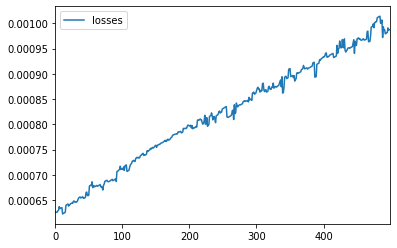

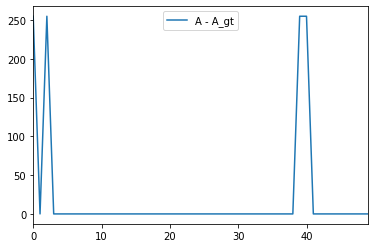

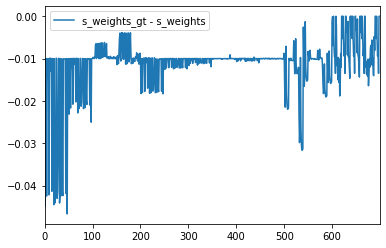

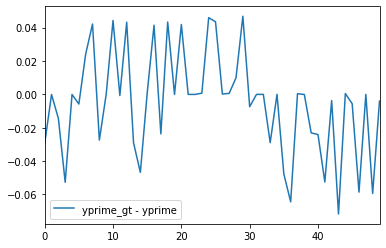

In [4]:
#
# Train for some number of iterations.
# This block can be rerun to continue training.
#

optimizer = torch.optim.SGD([s_weights, m_weights], lr=1)
for i in range(500):
    optimizer.zero_grad()
    
    yprime = deep_mnp(s_weights, m_weights, n, layer_sizes)
    #loss = loss_fn(yprime)
    loss = torch.mean((yprime - yprime_gt)**2)

    loss.backward(retain_graph=True)
    optimizer.step()
    s_weights.data.clamp_(min=0.0) #TODO: might be messing things up
    
    if iter_num % 50 == 0:   
        print('iteration ' + str(iter_num) + ' loss ' + str(loss.item()), end = '\n')
    losses.append(loss.item())
        
    if(iter_num == 0 or loss < best_loss):
        best_loss = loss
        best_s_weights = s_weights
        best_m_weights = m_weights
        
    iter_num += 1

print(yprime)
A = (yprime <= 0.0).numpy()
F_A = mnp.dsf_eval(n, layer_sizes, s_weights.detach().numpy(), m_weights.detach().numpy(),  A)
print(' F_A ' + str (F_A))
       
df = pd.DataFrame(losses, columns=('losses',))
df.plot()
print(A)
print(A_gt)
df = pd.DataFrame(A-A_gt, columns=('A - A_gt',))
df.plot()
df = pd.DataFrame(sub_weights_gt - s_weights.detach().numpy(), columns = ('s_weights_gt - s_weights',))
df.plot()
df = pd.DataFrame((yprime_gt - yprime).detach().numpy(), columns = ('yprime_gt - yprime',))
df.plot()
plt.show()

Ground Truth F_A*:	-4.669107750273742
Ground Truth |A*|:	77
iteration 0 loss 74.08938377729847
iteration 50 loss 4.12319977208695
iteration 100 loss 2.2962843038963703
iteration 150 loss 1.3559741597570252
iteration 200 loss 1.0069413218385463
iteration 250 loss 0.8023609763860822
 F_A -373.7551712913252


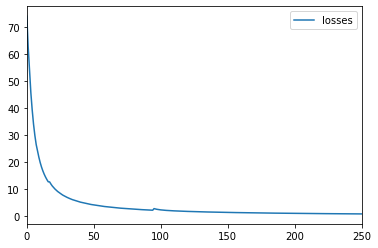

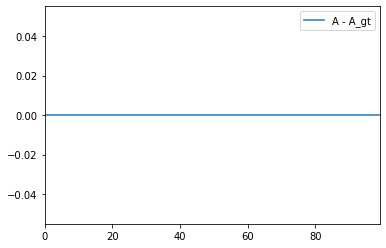

In [23]:
#
# Now create and fit a graph cut submodular function
#

#First create a ground truth submodular function to fit
n = 100
FA_gt, yprime_gt = mnp.watts_strogatz_graph_cut_yprime(n, 16, 0.25)

card = np.count_nonzero(yprime_gt <= 0.0)
print('Ground Truth F_A*:\t' + str(FA_gt))
print('Ground Truth |A*|:\t' + str(card))

yprime_gt = torch.tensor(yprime_gt)

A_gt = torch.ones(n, dtype=torch.float64)
for i in range(n):
    if yprime_gt[i].item() <= 0.0:
        A_gt[i] = 1.0
    else:
        A_gt[i] = 0.0

#Initalize weights/variables
layer_sizes = np.ones(3, dtype=np.int64)
layer_sizes *= 10
n_sub_weights = n * np.prod(layer_sizes)

s_weights = torch.zeros(n_sub_weights, dtype=torch.float64)
s_weights.uniform_(0.0, 1.0)
s_weights.requires_grad=True
m_weights = torch.randn(n, dtype=torch.float64, requires_grad=True)

#Create Model
deep_mnp = mnp.DeepSubmodular.apply
loss_fn = mnp.LogQ(A_gt)

#Use SGD to train model
optimizer = torch.optim.SGD([s_weights, m_weights], lr=5e-1)
losses = []
best_loss = 0
for iter_num in range(251):
    optimizer.zero_grad()
    
    yprime = deep_mnp(s_weights, m_weights, n, layer_sizes)
    loss = loss_fn(yprime)

    loss.backward(retain_graph=True)
    optimizer.step()
    s_weights.data.clamp_(min=0.0)
    
    if iter_num % 50 == 0:   
        print('iteration ' + str(iter_num) + ' loss ' + str(loss.item()), end = '\n')
    losses.append(loss.item())
        
    if(iter_num == 0 or loss < best_loss):
        best_loss = loss
        best_s_weights = s_weights
        best_m_weights = m_weights
        
A = (yprime <= 0.0).numpy()
F_A = mnp.dsf_eval(n, layer_sizes, s_weights.detach().numpy(), m_weights.detach().numpy(),  A)
print(' F_A ' + str (F_A))
       
df = pd.DataFrame(losses, columns=('losses',))
df.plot()
df = pd.DataFrame(A-A_gt.numpy(), columns=('A - A_gt',))
df.plot()
plt.show()